In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

/home/pqul/Bureau/BNN_Xperience/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
SENSOR_SIZE = (128, 128, 2)
batch_size = 12

Dataset_path = '../data'
Workers = 8
Targetnum = 11

Test_every_iteration = None
Name_suffix = '_step2_pos_neg_diff'
Savemodel_path = './savemodels_DVS/'
Record_path = './recorddata_DVS/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)


def collate_fn(batch):
    """Fonction personnalisée pour collate les événements de longueur variable"""
    events, targets = list(zip(*batch))
    return torch.tensor(events), torch.tensor(targets)

_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:


# Set paths
output_dir = "../processed_dvsgesture"
train_data_path = os.path.join(output_dir, "train_data.pkl")
test_data_path = os.path.join(output_dir, "test_data.pkl")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if processed data already exists
if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    # Load processed data
    with open(train_data_path, "rb") as f:
        train_images, train_labels = pickle.load(f)
    with open(test_data_path, "rb") as f:
        test_images, test_labels = pickle.load(f)
    print("Loaded preprocessed data from files")
else:
    # Process data from scratch
    transform = transforms.Compose([
        transforms.Denoise(filter_time=10000),
        transforms.ToFrame(sensor_size=SENSOR_SIZE, time_window=50000)
    ])
    
    # Load datasets
    dataset_train = tonic.datasets.DVSGesture(save_to=Dataset_path, train=True, transform=transform)
    dataset_test = tonic.datasets.DVSGesture(save_to=Dataset_path, train=False, transform=transform)
    
    # Function to convert sequences to images
    def convert_to_single_image(frame_sequence, method='combined'):
        time_steps, channels, height, width = frame_sequence.shape
        pos_sum = np.sum(frame_sequence[:, 0, :, :], axis=0)
        neg_sum = np.sum(frame_sequence[:, 1, :, :], axis=0)
        
        if method == 'diff':
            diff = pos_sum - neg_sum
            max_abs = max(np.abs(diff).max(), 1e-6)
            return np.expand_dims(diff / max_abs, axis=0)
        elif method == 'combined':
            result = np.zeros((3, height, width))
            result[0] = pos_sum / max(pos_sum.max(), 1e-6)
            result[1] = neg_sum / max(neg_sum.max(), 1e-6)
            diff = pos_sum - neg_sum
            result[2] = (diff / max(np.abs(diff).max(), 1e-6) + 1) / 2
            return result
    
    # Process training data
    train_images = []
    train_labels = []
    for i, (frames, label) in enumerate(dataset_train):
        if i % 100 == 0:
            print(f"Processing training sample {i}/{len(dataset_train)}")
        img = convert_to_single_image(frames, method='combined')
        train_images.append(torch.FloatTensor(img))
        train_labels.append(label)
    
    # Process test data
    test_images = []
    test_labels = []
    for i, (frames, label) in enumerate(dataset_test):
        if i % 100 == 0:
            print(f"Processing test sample {i}/{len(dataset_test)}")
        img = convert_to_single_image(frames, method='combined')
        test_images.append(torch.FloatTensor(img))
        test_labels.append(label)
    
    # Save processed data
    with open(train_data_path, "wb") as f:
        pickle.dump((train_images, train_labels), f)
    with open(test_data_path, "wb") as f:
        pickle.dump((test_images, test_labels), f)
    print("Saved preprocessed data to files")

# Create dataloaders
train_data_loader = torch.utils.data.DataLoader(
    list(zip(train_images, train_labels)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=Workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    list(zip(test_images, test_labels)),
    batch_size=batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True
)

2443675648it [03:12, 12715979.78it/s]                                


Extracting ../data/DVSGesture/ibmGestureTrain.tar.gz to ../data/DVSGesture


691456000it [01:01, 11278093.03it/s]                               


Extracting ../data/DVSGesture/ibmGestureTest.tar.gz to ../data/DVSGesture
Processing training sample 0/1077
Processing training sample 100/1077
Processing training sample 200/1077
Processing training sample 300/1077
Processing training sample 400/1077
Processing training sample 500/1077
Processing training sample 600/1077
Processing training sample 700/1077
Processing training sample 800/1077
Processing training sample 900/1077
Processing training sample 1000/1077
Processing test sample 0/264
Processing test sample 100/264
Processing test sample 200/264
Saved preprocessed data to files


/home/pqul/Bureau/AB-BNN/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


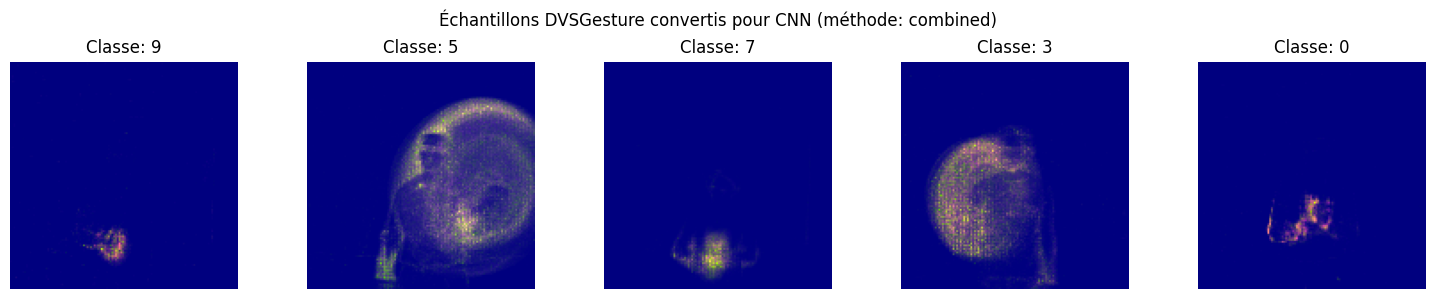

In [4]:
def visualize_cnn_samples(dataloader, method, num_samples=5):
    """Visualise quelques échantillons du dataloader pour CNN"""
    images, labels = next(iter(dataloader))
    
    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        image = images[i].numpy()  # (C, H, W)
        
        if method == 'combined':
            # Image RGB
            img = np.transpose(image, (1, 2, 0))
            axes[i].imshow(img)#np.clip(img, 0, 1))
        else:
            # Image en niveaux de gris
            axes[i].imshow(image[0], cmap='coolwarm', vmin=-1, vmax=1)
        
        axes[i].set_title(f"Classe: {labels[i].item()}")
        axes[i].axis('off')
    
    plt.suptitle(f"Échantillons DVSGesture convertis pour CNN (méthode: {method})")
    plt.tight_layout()
    plt.show()
visualize_cnn_samples(train_data_loader, method='combined', num_samples=5)

In [9]:
net = Reactnet(num_classes=Targetnum, imagenet=False)

In [11]:
#net = net.cuda()
max_test_acc = 0.
net.load_state_dict(torch.load(Savemodel_path + f'epoch{255}{Name_suffix}.h5'))
max_test_acc = np.load(Savemodel_path + f'max_acc{Name_suffix}.npy')
max_test_acc = max_test_acc.item()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [15]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.

Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [16]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [17]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.cuda()
            label = label.cuda()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [18]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.cuda()
        label = label.cuda()
        
        out_fr = net(img)
        loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        loss.backward()

        parameters_list = []
        for name, p in net.named_parameters():
            if not 'fc' in name:
                parameters_list.append(p)
        adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
        optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [19]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 22/22 [00:01<00:00, 15.04it/s]


epoch=0, train_acc_top1=0.0836, train_acc_top5=0.4336, train_loss=8.8392, test_top1=0.0909, test_top5=0.4053, test_loss=4.8455, max_test_acc=0.0909, total_time=19.3056, LR=0.00100000


100%|██████████| 22/22 [00:01<00:00, 15.11it/s]


epoch=1, train_acc_top1=0.1161, train_acc_top5=0.5627, train_loss=3.3660, test_top1=0.1742, test_top5=0.6818, test_loss=3.5545, max_test_acc=0.1742, total_time=18.2367, LR=0.00099609


100%|██████████| 22/22 [00:01<00:00, 15.07it/s]


epoch=2, train_acc_top1=0.1560, train_acc_top5=0.6973, train_loss=2.7044, test_top1=0.2008, test_top5=0.7879, test_loss=1.9888, max_test_acc=0.2008, total_time=18.4469, LR=0.00099219


100%|██████████| 22/22 [00:01<00:00, 15.18it/s]


epoch=3, train_acc_top1=0.1671, train_acc_top5=0.7168, train_loss=2.5967, test_top1=0.2727, test_top5=0.6174, test_loss=2.3945, max_test_acc=0.2727, total_time=18.3007, LR=0.00098828


100%|██████████| 22/22 [00:01<00:00, 15.04it/s]


epoch=4, train_acc_top1=0.2201, train_acc_top5=0.7818, train_loss=2.2749, test_top1=0.3258, test_top5=0.9621, test_loss=1.7279, max_test_acc=0.3258, total_time=18.4930, LR=0.00098438


100%|██████████| 22/22 [00:01<00:00, 15.24it/s]


epoch=5, train_acc_top1=0.3305, train_acc_top5=0.8477, train_loss=1.9061, test_top1=0.3939, test_top5=0.9621, test_loss=1.8991, max_test_acc=0.3939, total_time=18.7600, LR=0.00098047


100%|██████████| 22/22 [00:01<00:00, 14.92it/s]


epoch=6, train_acc_top1=0.4234, train_acc_top5=0.9201, train_loss=1.5401, test_top1=0.4811, test_top5=0.9773, test_loss=1.3057, max_test_acc=0.4811, total_time=18.3458, LR=0.00097656


100%|██████████| 22/22 [00:01<00:00, 14.91it/s]


epoch=7, train_acc_top1=0.4271, train_acc_top5=0.9424, train_loss=1.4559, test_top1=0.4697, test_top5=0.8826, test_loss=1.4110, max_test_acc=0.4811, total_time=18.3229, LR=0.00097266


100%|██████████| 22/22 [00:01<00:00, 15.00it/s]


epoch=8, train_acc_top1=0.4225, train_acc_top5=0.9034, train_loss=1.7734, test_top1=0.4697, test_top5=0.9508, test_loss=1.4422, max_test_acc=0.4811, total_time=18.3478, LR=0.00096875


100%|██████████| 22/22 [00:01<00:00, 15.03it/s]


epoch=9, train_acc_top1=0.4178, train_acc_top5=0.9109, train_loss=1.8503, test_top1=0.4659, test_top5=0.9053, test_loss=1.3792, max_test_acc=0.4811, total_time=18.1497, LR=0.00096484


100%|██████████| 22/22 [00:01<00:00, 14.85it/s]


epoch=10, train_acc_top1=0.4828, train_acc_top5=0.9694, train_loss=1.3179, test_top1=0.5682, test_top5=0.9962, test_loss=1.2645, max_test_acc=0.5682, total_time=18.3746, LR=0.00096094


100%|██████████| 22/22 [00:01<00:00, 14.98it/s]


epoch=11, train_acc_top1=0.5042, train_acc_top5=0.9452, train_loss=1.4139, test_top1=0.5000, test_top5=0.9167, test_loss=1.5557, max_test_acc=0.5682, total_time=18.5050, LR=0.00095703


100%|██████████| 22/22 [00:01<00:00, 14.99it/s]


epoch=12, train_acc_top1=0.5432, train_acc_top5=0.9731, train_loss=1.1597, test_top1=0.5644, test_top5=0.9583, test_loss=1.0845, max_test_acc=0.5682, total_time=18.4110, LR=0.00095312


100%|██████████| 22/22 [00:01<00:00, 15.02it/s]


epoch=13, train_acc_top1=0.5729, train_acc_top5=0.9675, train_loss=1.1599, test_top1=0.6364, test_top5=1.0000, test_loss=0.8380, max_test_acc=0.6364, total_time=18.4620, LR=0.00094922


100%|██████████| 22/22 [00:01<00:00, 14.99it/s]


epoch=14, train_acc_top1=0.6184, train_acc_top5=0.9842, train_loss=0.9239, test_top1=0.6553, test_top5=1.0000, test_loss=0.8075, max_test_acc=0.6553, total_time=18.4185, LR=0.00094531


100%|██████████| 22/22 [00:01<00:00, 15.13it/s]


epoch=15, train_acc_top1=0.6518, train_acc_top5=0.9916, train_loss=0.8461, test_top1=0.6098, test_top5=0.9773, test_loss=0.8622, max_test_acc=0.6553, total_time=18.1301, LR=0.00094141


100%|██████████| 22/22 [00:01<00:00, 14.88it/s]


epoch=16, train_acc_top1=0.6565, train_acc_top5=0.9963, train_loss=0.7876, test_top1=0.7008, test_top5=1.0000, test_loss=0.6556, max_test_acc=0.7008, total_time=18.5046, LR=0.00093750


100%|██████████| 22/22 [00:01<00:00, 15.09it/s]


epoch=17, train_acc_top1=0.6685, train_acc_top5=0.9944, train_loss=0.7905, test_top1=0.6136, test_top5=0.9886, test_loss=0.9137, max_test_acc=0.7008, total_time=18.2777, LR=0.00093359


100%|██████████| 22/22 [00:01<00:00, 15.18it/s]


epoch=18, train_acc_top1=0.6834, train_acc_top5=0.9963, train_loss=0.7455, test_top1=0.6439, test_top5=0.9962, test_loss=0.8171, max_test_acc=0.7008, total_time=18.1449, LR=0.00092969


100%|██████████| 22/22 [00:01<00:00, 15.11it/s]


epoch=19, train_acc_top1=0.7084, train_acc_top5=0.9954, train_loss=0.6766, test_top1=0.7045, test_top5=0.9962, test_loss=0.6542, max_test_acc=0.7045, total_time=18.3437, LR=0.00092578


100%|██████████| 22/22 [00:01<00:00, 15.05it/s]


epoch=20, train_acc_top1=0.6936, train_acc_top5=0.9907, train_loss=0.7605, test_top1=0.7311, test_top5=0.9886, test_loss=0.6787, max_test_acc=0.7311, total_time=18.5439, LR=0.00092188


100%|██████████| 22/22 [00:01<00:00, 15.14it/s]


epoch=21, train_acc_top1=0.7586, train_acc_top5=0.9963, train_loss=0.6118, test_top1=0.7159, test_top5=0.9886, test_loss=0.7936, max_test_acc=0.7311, total_time=18.3480, LR=0.00091797


100%|██████████| 22/22 [00:01<00:00, 14.96it/s]


epoch=22, train_acc_top1=0.7642, train_acc_top5=0.9944, train_loss=0.5677, test_top1=0.7311, test_top5=0.9962, test_loss=0.6554, max_test_acc=0.7311, total_time=18.3621, LR=0.00091406


100%|██████████| 22/22 [00:01<00:00, 14.97it/s]


epoch=23, train_acc_top1=0.7781, train_acc_top5=0.9963, train_loss=0.5468, test_top1=0.7500, test_top5=0.9962, test_loss=0.6427, max_test_acc=0.7500, total_time=18.4407, LR=0.00091016


100%|██████████| 22/22 [00:01<00:00, 15.05it/s]


epoch=24, train_acc_top1=0.7614, train_acc_top5=0.9981, train_loss=0.5597, test_top1=0.6780, test_top5=0.9962, test_loss=0.7615, max_test_acc=0.7500, total_time=18.1950, LR=0.00090625


100%|██████████| 22/22 [00:01<00:00, 14.82it/s]


epoch=25, train_acc_top1=0.7809, train_acc_top5=0.9981, train_loss=0.4883, test_top1=0.7348, test_top5=0.9848, test_loss=0.6424, max_test_acc=0.7500, total_time=18.3708, LR=0.00090234


100%|██████████| 22/22 [00:01<00:00, 15.03it/s]


epoch=26, train_acc_top1=0.7874, train_acc_top5=0.9907, train_loss=0.5332, test_top1=0.7348, test_top5=0.9848, test_loss=0.6716, max_test_acc=0.7500, total_time=18.3749, LR=0.00089844


100%|██████████| 22/22 [00:01<00:00, 14.88it/s]


epoch=27, train_acc_top1=0.8273, train_acc_top5=0.9991, train_loss=0.4411, test_top1=0.7462, test_top5=1.0000, test_loss=0.6135, max_test_acc=0.7500, total_time=18.1996, LR=0.00089453


100%|██████████| 22/22 [00:01<00:00, 15.05it/s]


epoch=28, train_acc_top1=0.7957, train_acc_top5=0.9963, train_loss=0.5192, test_top1=0.7803, test_top5=0.9924, test_loss=0.5630, max_test_acc=0.7803, total_time=18.4326, LR=0.00089063


100%|██████████| 22/22 [00:01<00:00, 15.03it/s]


epoch=29, train_acc_top1=0.8570, train_acc_top5=0.9981, train_loss=0.4027, test_top1=0.7689, test_top5=0.9886, test_loss=0.9009, max_test_acc=0.7803, total_time=18.1787, LR=0.00088672


100%|██████████| 22/22 [00:01<00:00, 14.94it/s]


epoch=30, train_acc_top1=0.8626, train_acc_top5=0.9991, train_loss=0.3640, test_top1=0.7727, test_top5=0.9811, test_loss=0.6166, max_test_acc=0.7803, total_time=18.1827, LR=0.00088281


100%|██████████| 22/22 [00:01<00:00, 14.87it/s]


epoch=31, train_acc_top1=0.8598, train_acc_top5=0.9972, train_loss=0.3558, test_top1=0.7462, test_top5=0.9848, test_loss=0.6230, max_test_acc=0.7803, total_time=18.2780, LR=0.00087891


100%|██████████| 22/22 [00:01<00:00, 14.75it/s]


epoch=32, train_acc_top1=0.8923, train_acc_top5=0.9991, train_loss=0.3332, test_top1=0.7500, test_top5=0.9886, test_loss=0.7661, max_test_acc=0.7803, total_time=18.5692, LR=0.00087500


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=33, train_acc_top1=0.9034, train_acc_top5=0.9991, train_loss=0.2837, test_top1=0.7652, test_top5=1.0000, test_loss=0.6688, max_test_acc=0.7803, total_time=16.5551, LR=0.00087109


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=34, train_acc_top1=0.8960, train_acc_top5=0.9991, train_loss=0.2946, test_top1=0.8068, test_top5=1.0000, test_loss=0.5591, max_test_acc=0.8068, total_time=16.4758, LR=0.00086719


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=35, train_acc_top1=0.8756, train_acc_top5=0.9954, train_loss=0.3613, test_top1=0.7689, test_top5=0.9962, test_loss=0.7419, max_test_acc=0.8068, total_time=16.3384, LR=0.00086328


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=36, train_acc_top1=0.8895, train_acc_top5=0.9981, train_loss=0.2965, test_top1=0.7576, test_top5=0.9924, test_loss=0.7806, max_test_acc=0.8068, total_time=16.3362, LR=0.00085938


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=37, train_acc_top1=0.8979, train_acc_top5=0.9991, train_loss=0.2616, test_top1=0.7955, test_top5=0.9962, test_loss=0.7798, max_test_acc=0.8068, total_time=16.3330, LR=0.00085547


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=38, train_acc_top1=0.9164, train_acc_top5=1.0000, train_loss=0.2224, test_top1=0.8220, test_top5=0.9848, test_loss=0.5928, max_test_acc=0.8220, total_time=16.4985, LR=0.00085156


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=39, train_acc_top1=0.8867, train_acc_top5=0.9963, train_loss=0.3186, test_top1=0.7803, test_top5=0.9886, test_loss=0.6743, max_test_acc=0.8220, total_time=16.3268, LR=0.00084766


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=40, train_acc_top1=0.9090, train_acc_top5=0.9991, train_loss=0.2376, test_top1=0.7803, test_top5=0.9886, test_loss=0.6674, max_test_acc=0.8220, total_time=16.3267, LR=0.00084375


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=41, train_acc_top1=0.9424, train_acc_top5=0.9991, train_loss=0.1618, test_top1=0.7917, test_top5=0.9924, test_loss=0.7114, max_test_acc=0.8220, total_time=16.3498, LR=0.00083984


100%|██████████| 22/22 [00:01<00:00, 16.71it/s]


epoch=42, train_acc_top1=0.9434, train_acc_top5=1.0000, train_loss=0.1584, test_top1=0.8030, test_top5=0.9924, test_loss=0.6354, max_test_acc=0.8220, total_time=16.3417, LR=0.00083594


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=43, train_acc_top1=0.9443, train_acc_top5=0.9991, train_loss=0.1565, test_top1=0.8106, test_top5=1.0000, test_loss=0.6593, max_test_acc=0.8220, total_time=16.3062, LR=0.00083203


100%|██████████| 22/22 [00:01<00:00, 15.53it/s]


epoch=44, train_acc_top1=0.9443, train_acc_top5=0.9991, train_loss=0.1750, test_top1=0.7803, test_top5=1.0000, test_loss=0.6555, max_test_acc=0.8220, total_time=16.5465, LR=0.00082812


100%|██████████| 22/22 [00:01<00:00, 15.01it/s]


epoch=45, train_acc_top1=0.9099, train_acc_top5=0.9898, train_loss=0.3815, test_top1=0.7955, test_top5=1.0000, test_loss=0.6651, max_test_acc=0.8220, total_time=18.3338, LR=0.00082422


100%|██████████| 22/22 [00:01<00:00, 15.15it/s]


epoch=46, train_acc_top1=0.9350, train_acc_top5=1.0000, train_loss=0.1904, test_top1=0.7538, test_top5=0.9886, test_loss=0.8058, max_test_acc=0.8220, total_time=18.1733, LR=0.00082031


100%|██████████| 22/22 [00:01<00:00, 15.12it/s]


epoch=47, train_acc_top1=0.9396, train_acc_top5=1.0000, train_loss=0.1808, test_top1=0.8106, test_top5=1.0000, test_loss=0.6413, max_test_acc=0.8220, total_time=18.1390, LR=0.00081641


100%|██████████| 22/22 [00:01<00:00, 15.25it/s]


epoch=48, train_acc_top1=0.9564, train_acc_top5=1.0000, train_loss=0.1168, test_top1=0.7689, test_top5=0.9924, test_loss=0.8656, max_test_acc=0.8220, total_time=18.0511, LR=0.00081250


100%|██████████| 22/22 [00:01<00:00, 15.22it/s]


epoch=49, train_acc_top1=0.9573, train_acc_top5=1.0000, train_loss=0.1244, test_top1=0.8333, test_top5=0.9962, test_loss=0.7205, max_test_acc=0.8333, total_time=18.1983, LR=0.00080859


100%|██████████| 22/22 [00:01<00:00, 15.21it/s]


epoch=50, train_acc_top1=0.9127, train_acc_top5=0.9963, train_loss=0.3272, test_top1=0.7576, test_top5=0.9886, test_loss=0.6840, max_test_acc=0.8333, total_time=18.1244, LR=0.00080469


100%|██████████| 22/22 [00:01<00:00, 15.32it/s]


epoch=51, train_acc_top1=0.9350, train_acc_top5=0.9991, train_loss=0.2006, test_top1=0.8371, test_top5=1.0000, test_loss=0.5450, max_test_acc=0.8371, total_time=18.3310, LR=0.00080078


100%|██████████| 22/22 [00:01<00:00, 15.13it/s]


epoch=52, train_acc_top1=0.9591, train_acc_top5=1.0000, train_loss=0.1359, test_top1=0.8068, test_top5=0.9811, test_loss=0.8903, max_test_acc=0.8371, total_time=18.2854, LR=0.00079688


100%|██████████| 22/22 [00:01<00:00, 15.03it/s]


epoch=53, train_acc_top1=0.9703, train_acc_top5=1.0000, train_loss=0.0925, test_top1=0.7992, test_top5=0.9811, test_loss=0.8309, max_test_acc=0.8371, total_time=18.1526, LR=0.00079297


100%|██████████| 22/22 [00:01<00:00, 15.13it/s]


epoch=54, train_acc_top1=0.9675, train_acc_top5=1.0000, train_loss=0.0993, test_top1=0.7879, test_top5=0.9848, test_loss=0.8597, max_test_acc=0.8371, total_time=18.1543, LR=0.00078906


100%|██████████| 22/22 [00:01<00:00, 15.28it/s]


epoch=55, train_acc_top1=0.9638, train_acc_top5=1.0000, train_loss=0.1133, test_top1=0.7917, test_top5=0.9735, test_loss=0.7720, max_test_acc=0.8371, total_time=18.0699, LR=0.00078516


100%|██████████| 22/22 [00:01<00:00, 15.35it/s]


epoch=56, train_acc_top1=0.9499, train_acc_top5=1.0000, train_loss=0.1414, test_top1=0.7500, test_top5=0.9886, test_loss=0.8380, max_test_acc=0.8371, total_time=18.0286, LR=0.00078125


100%|██████████| 22/22 [00:01<00:00, 15.32it/s]


epoch=57, train_acc_top1=0.9619, train_acc_top5=1.0000, train_loss=0.1186, test_top1=0.8182, test_top5=0.9811, test_loss=0.7437, max_test_acc=0.8371, total_time=18.0700, LR=0.00077734


100%|██████████| 22/22 [00:01<00:00, 15.21it/s]


epoch=58, train_acc_top1=0.9703, train_acc_top5=0.9991, train_loss=0.1067, test_top1=0.8220, test_top5=0.9735, test_loss=0.8384, max_test_acc=0.8371, total_time=18.0236, LR=0.00077344


100%|██████████| 22/22 [00:01<00:00, 15.12it/s]


epoch=59, train_acc_top1=0.9721, train_acc_top5=1.0000, train_loss=0.1003, test_top1=0.7992, test_top5=0.9773, test_loss=0.7864, max_test_acc=0.8371, total_time=18.1081, LR=0.00076953


100%|██████████| 22/22 [00:01<00:00, 15.03it/s]


epoch=60, train_acc_top1=0.9777, train_acc_top5=0.9991, train_loss=0.0664, test_top1=0.8144, test_top5=0.9886, test_loss=1.0201, max_test_acc=0.8371, total_time=18.1911, LR=0.00076563


100%|██████████| 22/22 [00:01<00:00, 14.95it/s]


epoch=61, train_acc_top1=0.9554, train_acc_top5=0.9944, train_loss=0.2376, test_top1=0.7652, test_top5=0.9659, test_loss=1.1249, max_test_acc=0.8371, total_time=18.2455, LR=0.00076172


100%|██████████| 22/22 [00:01<00:00, 15.27it/s]


epoch=62, train_acc_top1=0.9619, train_acc_top5=1.0000, train_loss=0.1161, test_top1=0.7917, test_top5=0.9962, test_loss=0.7409, max_test_acc=0.8371, total_time=18.1630, LR=0.00075781


100%|██████████| 22/22 [00:01<00:00, 15.04it/s]


epoch=63, train_acc_top1=0.9759, train_acc_top5=1.0000, train_loss=0.0891, test_top1=0.8220, test_top5=0.9583, test_loss=0.8641, max_test_acc=0.8371, total_time=18.2564, LR=0.00075391


100%|██████████| 22/22 [00:01<00:00, 15.25it/s]


epoch=64, train_acc_top1=0.9805, train_acc_top5=1.0000, train_loss=0.0575, test_top1=0.7955, test_top5=0.9924, test_loss=0.8744, max_test_acc=0.8371, total_time=18.1354, LR=0.00075000


100%|██████████| 22/22 [00:01<00:00, 15.22it/s]


epoch=65, train_acc_top1=0.9740, train_acc_top5=1.0000, train_loss=0.1034, test_top1=0.8144, test_top5=0.9886, test_loss=0.8954, max_test_acc=0.8371, total_time=18.0267, LR=0.00074609


100%|██████████| 22/22 [00:01<00:00, 15.15it/s]


epoch=66, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0933, test_top1=0.7917, test_top5=0.9962, test_loss=1.0201, max_test_acc=0.8371, total_time=18.0583, LR=0.00074219


100%|██████████| 22/22 [00:01<00:00, 15.21it/s]


epoch=67, train_acc_top1=0.9211, train_acc_top5=0.9935, train_loss=0.4883, test_top1=0.8106, test_top5=0.9848, test_loss=0.8010, max_test_acc=0.8371, total_time=18.0320, LR=0.00073828


100%|██████████| 22/22 [00:01<00:00, 14.99it/s]


epoch=68, train_acc_top1=0.9582, train_acc_top5=0.9954, train_loss=0.1612, test_top1=0.8068, test_top5=0.9848, test_loss=0.8719, max_test_acc=0.8371, total_time=18.2039, LR=0.00073438


100%|██████████| 22/22 [00:01<00:00, 15.10it/s]


epoch=69, train_acc_top1=0.9768, train_acc_top5=1.0000, train_loss=0.0615, test_top1=0.7765, test_top5=0.9886, test_loss=1.1555, max_test_acc=0.8371, total_time=18.1553, LR=0.00073047


100%|██████████| 22/22 [00:01<00:00, 15.01it/s]


epoch=70, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0527, test_top1=0.7803, test_top5=1.0000, test_loss=1.1887, max_test_acc=0.8371, total_time=18.1935, LR=0.00072656


100%|██████████| 22/22 [00:01<00:00, 15.24it/s]


epoch=71, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0640, test_top1=0.7803, test_top5=0.9848, test_loss=1.0217, max_test_acc=0.8371, total_time=18.1538, LR=0.00072266


100%|██████████| 22/22 [00:01<00:00, 15.14it/s]


epoch=72, train_acc_top1=0.9656, train_acc_top5=1.0000, train_loss=0.0953, test_top1=0.7803, test_top5=0.9962, test_loss=1.0184, max_test_acc=0.8371, total_time=18.1914, LR=0.00071875


100%|██████████| 22/22 [00:01<00:00, 15.26it/s]


epoch=73, train_acc_top1=0.9759, train_acc_top5=0.9991, train_loss=0.0747, test_top1=0.7992, test_top5=1.0000, test_loss=0.7981, max_test_acc=0.8371, total_time=18.2855, LR=0.00071484


100%|██████████| 22/22 [00:01<00:00, 15.22it/s]


epoch=74, train_acc_top1=0.9814, train_acc_top5=1.0000, train_loss=0.0547, test_top1=0.8182, test_top5=0.9924, test_loss=0.8532, max_test_acc=0.8371, total_time=18.0404, LR=0.00071094


100%|██████████| 22/22 [00:01<00:00, 15.29it/s]


epoch=75, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0662, test_top1=0.8220, test_top5=0.9924, test_loss=0.9232, max_test_acc=0.8371, total_time=18.0867, LR=0.00070703


100%|██████████| 22/22 [00:01<00:00, 15.12it/s]


epoch=76, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0315, test_top1=0.8106, test_top5=0.9962, test_loss=0.8473, max_test_acc=0.8371, total_time=18.0339, LR=0.00070312


100%|██████████| 22/22 [00:01<00:00, 14.98it/s]


epoch=77, train_acc_top1=0.9508, train_acc_top5=0.9926, train_loss=0.2285, test_top1=0.7992, test_top5=0.9962, test_loss=1.5901, max_test_acc=0.8371, total_time=18.1245, LR=0.00069922


100%|██████████| 22/22 [00:01<00:00, 15.20it/s]


epoch=78, train_acc_top1=0.9666, train_acc_top5=1.0000, train_loss=0.1090, test_top1=0.8144, test_top5=1.0000, test_loss=0.7623, max_test_acc=0.8371, total_time=18.1778, LR=0.00069531


100%|██████████| 22/22 [00:01<00:00, 14.93it/s]


epoch=79, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0248, test_top1=0.8068, test_top5=0.9962, test_loss=1.0680, max_test_acc=0.8371, total_time=18.2552, LR=0.00069141


100%|██████████| 22/22 [00:01<00:00, 15.18it/s]


epoch=80, train_acc_top1=0.9851, train_acc_top5=1.0000, train_loss=0.0503, test_top1=0.7841, test_top5=0.9886, test_loss=1.2373, max_test_acc=0.8371, total_time=18.2955, LR=0.00068750


100%|██████████| 22/22 [00:01<00:00, 15.23it/s]


epoch=81, train_acc_top1=0.9090, train_acc_top5=0.9851, train_loss=0.3533, test_top1=0.7538, test_top5=1.0000, test_loss=1.0446, max_test_acc=0.8371, total_time=18.3831, LR=0.00068359


100%|██████████| 22/22 [00:01<00:00, 16.69it/s]


epoch=82, train_acc_top1=0.9740, train_acc_top5=1.0000, train_loss=0.0776, test_top1=0.7803, test_top5=0.9697, test_loss=1.0212, max_test_acc=0.8371, total_time=16.3936, LR=0.00067969


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=83, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0384, test_top1=0.7992, test_top5=0.9924, test_loss=0.8626, max_test_acc=0.8371, total_time=16.3888, LR=0.00067578


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=84, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0392, test_top1=0.8220, test_top5=0.9962, test_loss=1.0107, max_test_acc=0.8371, total_time=16.3881, LR=0.00067188


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=85, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0538, test_top1=0.7765, test_top5=0.9924, test_loss=1.1792, max_test_acc=0.8371, total_time=16.4008, LR=0.00066797


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=86, train_acc_top1=0.9508, train_acc_top5=0.9991, train_loss=0.2201, test_top1=0.8220, test_top5=0.9962, test_loss=0.7134, max_test_acc=0.8371, total_time=16.3839, LR=0.00066406


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=87, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0300, test_top1=0.8068, test_top5=0.9962, test_loss=0.9883, max_test_acc=0.8371, total_time=16.3575, LR=0.00066016


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=88, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0442, test_top1=0.7879, test_top5=0.9773, test_loss=1.1686, max_test_acc=0.8371, total_time=16.3904, LR=0.00065625


100%|██████████| 22/22 [00:01<00:00, 15.34it/s]


epoch=89, train_acc_top1=0.9805, train_acc_top5=1.0000, train_loss=0.0480, test_top1=0.8220, test_top5=0.9886, test_loss=0.8081, max_test_acc=0.8371, total_time=16.4294, LR=0.00065234


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=90, train_acc_top1=0.9963, train_acc_top5=1.0000, train_loss=0.0159, test_top1=0.8295, test_top5=1.0000, test_loss=0.8469, max_test_acc=0.8371, total_time=16.4003, LR=0.00064844


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=91, train_acc_top1=0.9842, train_acc_top5=1.0000, train_loss=0.0437, test_top1=0.7955, test_top5=0.9848, test_loss=1.1214, max_test_acc=0.8371, total_time=16.3467, LR=0.00064453


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=92, train_acc_top1=0.9954, train_acc_top5=1.0000, train_loss=0.0203, test_top1=0.7992, test_top5=0.9962, test_loss=0.9527, max_test_acc=0.8371, total_time=16.3669, LR=0.00064063


100%|██████████| 22/22 [00:01<00:00, 16.42it/s]


epoch=93, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0285, test_top1=0.7917, test_top5=0.9773, test_loss=1.2527, max_test_acc=0.8371, total_time=16.3954, LR=0.00063672


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=94, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0425, test_top1=0.8068, test_top5=0.9886, test_loss=0.9247, max_test_acc=0.8371, total_time=16.3341, LR=0.00063281


100%|██████████| 22/22 [00:01<00:00, 16.71it/s]


epoch=95, train_acc_top1=0.9833, train_acc_top5=0.9991, train_loss=0.0698, test_top1=0.7917, test_top5=0.9924, test_loss=0.8551, max_test_acc=0.8371, total_time=16.3490, LR=0.00062891


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=96, train_acc_top1=0.9814, train_acc_top5=1.0000, train_loss=0.0636, test_top1=0.8068, test_top5=0.9924, test_loss=0.8982, max_test_acc=0.8371, total_time=16.4202, LR=0.00062500


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=97, train_acc_top1=0.9824, train_acc_top5=1.0000, train_loss=0.0492, test_top1=0.7992, test_top5=0.9848, test_loss=0.9942, max_test_acc=0.8371, total_time=16.3270, LR=0.00062109


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=98, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0284, test_top1=0.8068, test_top5=0.9962, test_loss=0.8588, max_test_acc=0.8371, total_time=16.3496, LR=0.00061719


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=99, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0458, test_top1=0.7917, test_top5=1.0000, test_loss=1.1460, max_test_acc=0.8371, total_time=16.3265, LR=0.00061328


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=100, train_acc_top1=0.9071, train_acc_top5=0.9786, train_loss=0.6272, test_top1=0.8068, test_top5=1.0000, test_loss=0.7115, max_test_acc=0.8371, total_time=16.3294, LR=0.00060937


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=101, train_acc_top1=0.9601, train_acc_top5=0.9991, train_loss=0.1177, test_top1=0.8258, test_top5=0.9773, test_loss=0.8997, max_test_acc=0.8371, total_time=16.3712, LR=0.00060547


100%|██████████| 22/22 [00:01<00:00, 16.75it/s]


epoch=102, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0356, test_top1=0.7955, test_top5=0.9773, test_loss=1.4076, max_test_acc=0.8371, total_time=16.3388, LR=0.00060156


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=103, train_acc_top1=0.9842, train_acc_top5=1.0000, train_loss=0.0454, test_top1=0.8485, test_top5=0.9962, test_loss=0.8265, max_test_acc=0.8485, total_time=16.5169, LR=0.00059766


100%|██████████| 22/22 [00:01<00:00, 16.54it/s]


epoch=104, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0274, test_top1=0.8144, test_top5=0.9962, test_loss=1.0237, max_test_acc=0.8485, total_time=16.3443, LR=0.00059375


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=105, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0392, test_top1=0.8068, test_top5=0.9924, test_loss=0.9540, max_test_acc=0.8485, total_time=16.3958, LR=0.00058984


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=106, train_acc_top1=0.9954, train_acc_top5=1.0000, train_loss=0.0196, test_top1=0.8409, test_top5=1.0000, test_loss=0.9158, max_test_acc=0.8485, total_time=16.3113, LR=0.00058594


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=107, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0204, test_top1=0.7955, test_top5=0.9811, test_loss=1.1371, max_test_acc=0.8485, total_time=16.3488, LR=0.00058203


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=108, train_acc_top1=0.9647, train_acc_top5=0.9991, train_loss=0.2291, test_top1=0.7348, test_top5=0.9735, test_loss=1.2297, max_test_acc=0.8485, total_time=16.3445, LR=0.00057812


100%|██████████| 22/22 [00:01<00:00, 16.75it/s]


epoch=109, train_acc_top1=0.9331, train_acc_top5=0.9991, train_loss=0.2414, test_top1=0.7879, test_top5=0.9962, test_loss=0.7811, max_test_acc=0.8485, total_time=16.3503, LR=0.00057422


100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


epoch=110, train_acc_top1=0.9833, train_acc_top5=0.9991, train_loss=0.0638, test_top1=0.7841, test_top5=0.9773, test_loss=1.1669, max_test_acc=0.8485, total_time=16.3368, LR=0.00057031


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=111, train_acc_top1=0.9870, train_acc_top5=1.0000, train_loss=0.0508, test_top1=0.8106, test_top5=1.0000, test_loss=0.8243, max_test_acc=0.8485, total_time=16.3768, LR=0.00056641


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=112, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.8371, test_top5=1.0000, test_loss=0.8021, max_test_acc=0.8485, total_time=16.3298, LR=0.00056250


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=113, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.8409, test_top5=0.9924, test_loss=0.8289, max_test_acc=0.8485, total_time=16.3819, LR=0.00055859


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=114, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0003, test_top1=0.8371, test_top5=0.9962, test_loss=0.8380, max_test_acc=0.8485, total_time=16.3524, LR=0.00055469


100%|██████████| 22/22 [00:01<00:00, 16.72it/s]


epoch=115, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8333, test_top5=1.0000, test_loss=0.8311, max_test_acc=0.8485, total_time=16.3374, LR=0.00055078


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=116, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8295, test_top5=0.9962, test_loss=0.8258, max_test_acc=0.8485, total_time=16.3391, LR=0.00054688


100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


epoch=117, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8333, test_top5=0.9962, test_loss=0.8045, max_test_acc=0.8485, total_time=16.3486, LR=0.00054297


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=118, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8182, test_top5=1.0000, test_loss=0.8459, max_test_acc=0.8485, total_time=16.3660, LR=0.00053906


100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


epoch=119, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8258, test_top5=0.9962, test_loss=0.8624, max_test_acc=0.8485, total_time=16.3414, LR=0.00053516


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=120, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8295, test_top5=0.9962, test_loss=0.8038, max_test_acc=0.8485, total_time=16.3953, LR=0.00053125


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=121, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8447, test_top5=0.9962, test_loss=0.8578, max_test_acc=0.8485, total_time=16.3266, LR=0.00052734


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=122, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8295, test_top5=1.0000, test_loss=0.8663, max_test_acc=0.8485, total_time=16.3783, LR=0.00052344


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=123, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8371, test_top5=1.0000, test_loss=0.8790, max_test_acc=0.8485, total_time=16.3867, LR=0.00051953


100%|██████████| 22/22 [00:01<00:00, 16.77it/s]


epoch=124, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8371, test_top5=0.9962, test_loss=0.8911, max_test_acc=0.8485, total_time=16.3219, LR=0.00051563


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=125, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8220, test_top5=1.0000, test_loss=0.9322, max_test_acc=0.8485, total_time=16.3550, LR=0.00051172


100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


epoch=126, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8371, test_top5=1.0000, test_loss=0.9640, max_test_acc=0.8485, total_time=16.3553, LR=0.00050781


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=127, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=1.0000, test_loss=0.8865, max_test_acc=0.8485, total_time=16.3889, LR=0.00050391


100%|██████████| 22/22 [00:01<00:00, 16.69it/s]


epoch=128, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=0.9962, test_loss=0.9575, max_test_acc=0.8485, total_time=16.3333, LR=0.00050000


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=129, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=1.0000, test_loss=0.9862, max_test_acc=0.8485, total_time=16.3365, LR=0.00049609


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=130, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9962, test_loss=1.0128, max_test_acc=0.8485, total_time=16.3761, LR=0.00049219


100%|██████████| 22/22 [00:01<00:00, 16.43it/s]


epoch=131, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=1.0000, test_loss=0.9485, max_test_acc=0.8485, total_time=16.3955, LR=0.00048828


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=132, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=1.0000, test_loss=0.9689, max_test_acc=0.8485, total_time=16.3615, LR=0.00048437


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=133, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=1.0000, test_loss=0.9742, max_test_acc=0.8485, total_time=16.4009, LR=0.00048047


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=134, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8295, test_top5=1.0000, test_loss=0.9930, max_test_acc=0.8485, total_time=16.3831, LR=0.00047656


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=135, train_acc_top1=0.9006, train_acc_top5=0.9935, train_loss=0.3852, test_top1=0.7348, test_top5=0.9773, test_loss=1.1541, max_test_acc=0.8485, total_time=16.3527, LR=0.00047266


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=136, train_acc_top1=0.8626, train_acc_top5=0.9972, train_loss=0.4329, test_top1=0.6553, test_top5=0.9886, test_loss=1.5578, max_test_acc=0.8485, total_time=16.3848, LR=0.00046875


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=137, train_acc_top1=0.8812, train_acc_top5=0.9991, train_loss=0.3479, test_top1=0.7348, test_top5=0.9659, test_loss=1.2885, max_test_acc=0.8485, total_time=16.3824, LR=0.00046484


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=138, train_acc_top1=0.9164, train_acc_top5=1.0000, train_loss=0.2572, test_top1=0.7765, test_top5=0.9886, test_loss=0.9636, max_test_acc=0.8485, total_time=16.3437, LR=0.00046094


100%|██████████| 22/22 [00:01<00:00, 16.71it/s]


epoch=139, train_acc_top1=0.9415, train_acc_top5=0.9981, train_loss=0.1764, test_top1=0.7159, test_top5=0.9470, test_loss=1.3553, max_test_acc=0.8485, total_time=16.3780, LR=0.00045703


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=140, train_acc_top1=0.9610, train_acc_top5=1.0000, train_loss=0.1319, test_top1=0.7992, test_top5=0.9886, test_loss=0.8479, max_test_acc=0.8485, total_time=16.3633, LR=0.00045313


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=141, train_acc_top1=0.9591, train_acc_top5=1.0000, train_loss=0.1075, test_top1=0.8409, test_top5=1.0000, test_loss=0.7803, max_test_acc=0.8485, total_time=16.3459, LR=0.00044922


100%|██████████| 22/22 [00:01<00:00, 16.73it/s]


epoch=142, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0584, test_top1=0.7879, test_top5=0.9924, test_loss=1.0850, max_test_acc=0.8485, total_time=16.3727, LR=0.00044531


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=143, train_acc_top1=0.9842, train_acc_top5=1.0000, train_loss=0.0670, test_top1=0.7727, test_top5=0.9924, test_loss=0.9627, max_test_acc=0.8485, total_time=16.3305, LR=0.00044141


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=144, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0383, test_top1=0.8220, test_top5=0.9924, test_loss=1.0162, max_test_acc=0.8485, total_time=16.3578, LR=0.00043750


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=145, train_acc_top1=0.9935, train_acc_top5=1.0000, train_loss=0.0274, test_top1=0.8333, test_top5=0.9962, test_loss=0.9491, max_test_acc=0.8485, total_time=16.3378, LR=0.00043359


100%|██████████| 22/22 [00:01<00:00, 16.69it/s]


epoch=146, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0237, test_top1=0.8220, test_top5=0.9886, test_loss=0.7990, max_test_acc=0.8485, total_time=16.3310, LR=0.00042969


100%|██████████| 22/22 [00:01<00:00, 16.73it/s]


epoch=147, train_acc_top1=0.9164, train_acc_top5=0.9851, train_loss=0.9819, test_top1=0.8030, test_top5=0.9848, test_loss=0.7824, max_test_acc=0.8485, total_time=16.3492, LR=0.00042578


100%|██████████| 22/22 [00:01<00:00, 16.42it/s]


epoch=148, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0362, test_top1=0.8220, test_top5=0.9962, test_loss=0.8275, max_test_acc=0.8485, total_time=16.3961, LR=0.00042187


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=149, train_acc_top1=0.9954, train_acc_top5=1.0000, train_loss=0.0123, test_top1=0.8030, test_top5=0.9924, test_loss=0.8052, max_test_acc=0.8485, total_time=16.3607, LR=0.00041797


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=150, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0137, test_top1=0.7955, test_top5=0.9962, test_loss=0.9946, max_test_acc=0.8485, total_time=16.3697, LR=0.00041406


100%|██████████| 22/22 [00:01<00:00, 16.47it/s]


epoch=151, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0024, test_top1=0.8182, test_top5=0.9848, test_loss=1.0297, max_test_acc=0.8485, total_time=16.3893, LR=0.00041016


100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


epoch=152, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.8371, test_top5=0.9962, test_loss=0.8730, max_test_acc=0.8485, total_time=16.3174, LR=0.00040625


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=153, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0003, test_top1=0.8409, test_top5=0.9962, test_loss=0.8655, max_test_acc=0.8485, total_time=16.3773, LR=0.00040234


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=154, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8333, test_top5=0.9924, test_loss=0.8202, max_test_acc=0.8485, total_time=16.3610, LR=0.00039844


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=155, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8258, test_top5=0.9962, test_loss=0.8157, max_test_acc=0.8485, total_time=16.3389, LR=0.00039453


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=156, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9962, test_loss=0.8374, max_test_acc=0.8485, total_time=16.3258, LR=0.00039063


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=157, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8485, test_top5=0.9924, test_loss=0.8172, max_test_acc=0.8485, total_time=16.5541, LR=0.00038672


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=158, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8371, test_top5=0.9962, test_loss=0.7961, max_test_acc=0.8485, total_time=16.3612, LR=0.00038281


100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


epoch=159, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=0.9962, test_loss=0.8582, max_test_acc=0.8485, total_time=16.3438, LR=0.00037891


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=160, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8447, test_top5=0.9962, test_loss=0.8258, max_test_acc=0.8485, total_time=16.3437, LR=0.00037500


100%|██████████| 22/22 [00:01<00:00, 16.77it/s]


epoch=161, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9962, test_loss=0.8319, max_test_acc=0.8485, total_time=16.3563, LR=0.00037109


100%|██████████| 22/22 [00:01<00:00, 16.69it/s]


epoch=162, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8447, test_top5=0.9962, test_loss=0.8210, max_test_acc=0.8485, total_time=16.3619, LR=0.00036719


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=163, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8371, test_top5=0.9962, test_loss=0.8321, max_test_acc=0.8485, total_time=16.3648, LR=0.00036328


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=164, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=0.9962, test_loss=0.8216, max_test_acc=0.8485, total_time=16.3683, LR=0.00035937


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=165, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8447, test_top5=0.9962, test_loss=0.8647, max_test_acc=0.8485, total_time=16.3256, LR=0.00035547


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=166, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9962, test_loss=0.8535, max_test_acc=0.8485, total_time=16.4005, LR=0.00035156


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=167, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8295, test_top5=0.9962, test_loss=0.8838, max_test_acc=0.8485, total_time=16.3581, LR=0.00034766


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=168, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8295, test_top5=0.9962, test_loss=0.8782, max_test_acc=0.8485, total_time=16.3866, LR=0.00034375


100%|██████████| 22/22 [00:01<00:00, 16.54it/s]


epoch=169, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8523, test_top5=0.9962, test_loss=0.9365, max_test_acc=0.8523, total_time=16.5546, LR=0.00033984


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=170, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8258, test_top5=0.9962, test_loss=0.9185, max_test_acc=0.8523, total_time=16.3767, LR=0.00033594


100%|██████████| 22/22 [00:01<00:00, 16.46it/s]


epoch=171, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9962, test_loss=0.8860, max_test_acc=0.8523, total_time=16.3525, LR=0.00033203


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=172, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8295, test_top5=0.9962, test_loss=0.8826, max_test_acc=0.8523, total_time=16.3969, LR=0.00032813


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=173, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8295, test_top5=0.9886, test_loss=0.9049, max_test_acc=0.8523, total_time=16.3483, LR=0.00032422


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=174, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8220, test_top5=0.9962, test_loss=0.9481, max_test_acc=0.8523, total_time=16.3763, LR=0.00032031


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=175, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9962, test_loss=0.9247, max_test_acc=0.8523, total_time=16.4044, LR=0.00031641


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=176, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9924, test_loss=0.8905, max_test_acc=0.8523, total_time=16.3992, LR=0.00031250


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=177, train_acc_top1=0.9954, train_acc_top5=1.0000, train_loss=0.0191, test_top1=0.7538, test_top5=0.9773, test_loss=1.4309, max_test_acc=0.8523, total_time=16.3420, LR=0.00030859


100%|██████████| 22/22 [00:01<00:00, 16.47it/s]


epoch=178, train_acc_top1=0.8598, train_acc_top5=0.9944, train_loss=0.5545, test_top1=0.6894, test_top5=0.9470, test_loss=1.6506, max_test_acc=0.8523, total_time=16.3625, LR=0.00030469


100%|██████████| 22/22 [00:01<00:00, 16.40it/s]


epoch=179, train_acc_top1=0.8932, train_acc_top5=0.9935, train_loss=0.7406, test_top1=0.1212, test_top5=0.4697, test_loss=25.0729, max_test_acc=0.8523, total_time=16.3642, LR=0.00030078


100%|██████████| 22/22 [00:01<00:00, 16.43it/s]


epoch=180, train_acc_top1=0.9136, train_acc_top5=0.9926, train_loss=0.4284, test_top1=0.7803, test_top5=0.9886, test_loss=0.8815, max_test_acc=0.8523, total_time=16.4292, LR=0.00029687


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


epoch=181, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0668, test_top1=0.7955, test_top5=0.9924, test_loss=0.9461, max_test_acc=0.8523, total_time=16.3749, LR=0.00029297


100%|██████████| 22/22 [00:01<00:00, 16.54it/s]


epoch=182, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0664, test_top1=0.7955, test_top5=0.9924, test_loss=0.7435, max_test_acc=0.8523, total_time=16.4081, LR=0.00028906


100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


epoch=183, train_acc_top1=0.9861, train_acc_top5=1.0000, train_loss=0.0430, test_top1=0.8258, test_top5=0.9886, test_loss=0.9264, max_test_acc=0.8523, total_time=16.3706, LR=0.00028516


100%|██████████| 22/22 [00:01<00:00, 16.43it/s]


epoch=184, train_acc_top1=0.9759, train_acc_top5=1.0000, train_loss=0.0709, test_top1=0.7803, test_top5=0.9735, test_loss=1.1258, max_test_acc=0.8523, total_time=16.4011, LR=0.00028125


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=185, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0613, test_top1=0.8106, test_top5=0.9811, test_loss=1.0120, max_test_acc=0.8523, total_time=16.3699, LR=0.00027734


100%|██████████| 22/22 [00:01<00:00, 16.43it/s]


epoch=186, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0436, test_top1=0.8333, test_top5=0.9886, test_loss=0.7454, max_test_acc=0.8523, total_time=16.3720, LR=0.00027344


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=187, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0080, test_top1=0.8182, test_top5=0.9886, test_loss=0.9399, max_test_acc=0.8523, total_time=16.3762, LR=0.00026953


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=188, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0035, test_top1=0.7841, test_top5=0.9962, test_loss=1.0508, max_test_acc=0.8523, total_time=16.4041, LR=0.00026563


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=189, train_acc_top1=0.9889, train_acc_top5=0.9972, train_loss=0.0513, test_top1=0.8220, test_top5=0.9811, test_loss=1.0114, max_test_acc=0.8523, total_time=16.3805, LR=0.00026172


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=190, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0102, test_top1=0.8220, test_top5=0.9924, test_loss=1.1307, max_test_acc=0.8523, total_time=16.4162, LR=0.00025781


100%|██████████| 22/22 [00:01<00:00, 16.52it/s]


epoch=191, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0119, test_top1=0.8106, test_top5=0.9924, test_loss=0.9725, max_test_acc=0.8523, total_time=16.3538, LR=0.00025391


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=192, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0268, test_top1=0.8258, test_top5=0.9962, test_loss=0.9355, max_test_acc=0.8523, total_time=16.4897, LR=0.00025000


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=193, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0043, test_top1=0.8220, test_top5=0.9886, test_loss=0.9136, max_test_acc=0.8523, total_time=16.3712, LR=0.00024609


100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


epoch=194, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0003, test_top1=0.8371, test_top5=0.9886, test_loss=0.7758, max_test_acc=0.8523, total_time=16.3756, LR=0.00024219


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=195, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0002, test_top1=0.8409, test_top5=0.9886, test_loss=0.8313, max_test_acc=0.8523, total_time=16.3459, LR=0.00023828


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=196, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8485, test_top5=0.9886, test_loss=0.8173, max_test_acc=0.8523, total_time=16.3601, LR=0.00023437


100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


epoch=197, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8485, test_top5=0.9886, test_loss=0.8245, max_test_acc=0.8523, total_time=16.3469, LR=0.00023047


100%|██████████| 22/22 [00:01<00:00, 16.45it/s]


epoch=198, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=0.9886, test_loss=0.8523, max_test_acc=0.8523, total_time=16.3906, LR=0.00022656


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=199, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8333, test_top5=0.9886, test_loss=0.8712, max_test_acc=0.8523, total_time=16.3773, LR=0.00022266


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=200, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8409, test_top5=0.9924, test_loss=0.8381, max_test_acc=0.8523, total_time=16.3430, LR=0.00021875


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=201, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8447, test_top5=0.9886, test_loss=0.8175, max_test_acc=0.8523, total_time=16.3429, LR=0.00021484


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=202, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8485, test_top5=0.9886, test_loss=0.8165, max_test_acc=0.8523, total_time=16.3873, LR=0.00021094


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=203, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8523, test_top5=0.9886, test_loss=0.8130, max_test_acc=0.8523, total_time=16.5299, LR=0.00020703


100%|██████████| 22/22 [00:01<00:00, 16.46it/s]


epoch=204, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8485, test_top5=0.9886, test_loss=0.8553, max_test_acc=0.8523, total_time=16.3923, LR=0.00020313


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=205, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9886, test_loss=0.8742, max_test_acc=0.8523, total_time=16.3876, LR=0.00019922


100%|██████████| 22/22 [00:01<00:00, 16.52it/s]


epoch=206, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9924, test_loss=0.8690, max_test_acc=0.8523, total_time=16.3874, LR=0.00019531


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=207, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8523, test_top5=0.9886, test_loss=0.8721, max_test_acc=0.8523, total_time=16.5819, LR=0.00019141


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=208, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9886, test_loss=0.8894, max_test_acc=0.8523, total_time=16.3661, LR=0.00018750


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=209, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9886, test_loss=0.9064, max_test_acc=0.8523, total_time=16.3673, LR=0.00018359


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=210, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9886, test_loss=0.8983, max_test_acc=0.8523, total_time=16.3509, LR=0.00017969


100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


epoch=211, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9886, test_loss=0.9144, max_test_acc=0.8523, total_time=16.3414, LR=0.00017578


100%|██████████| 22/22 [00:01<00:00, 16.52it/s]


epoch=212, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8485, test_top5=0.9886, test_loss=0.8991, max_test_acc=0.8523, total_time=16.3883, LR=0.00017187


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=213, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9886, test_loss=0.9029, max_test_acc=0.8523, total_time=16.3456, LR=0.00016797


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=214, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9886, test_loss=0.8706, max_test_acc=0.8523, total_time=16.3270, LR=0.00016406


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=215, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8523, test_top5=0.9886, test_loss=0.8927, max_test_acc=0.8523, total_time=16.5516, LR=0.00016016


100%|██████████| 22/22 [00:01<00:00, 16.48it/s]


epoch=216, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9886, test_loss=0.9324, max_test_acc=0.8523, total_time=16.3872, LR=0.00015625


100%|██████████| 22/22 [00:01<00:00, 16.61it/s]


epoch=217, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9886, test_loss=0.9099, max_test_acc=0.8523, total_time=16.3582, LR=0.00015234


100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


epoch=218, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9924, test_loss=0.9550, max_test_acc=0.8523, total_time=16.3657, LR=0.00014844


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=219, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9375, max_test_acc=0.8523, total_time=16.3800, LR=0.00014453


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=220, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9924, test_loss=0.9386, max_test_acc=0.8523, total_time=16.3574, LR=0.00014063


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=221, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9924, test_loss=0.9304, max_test_acc=0.8523, total_time=16.3625, LR=0.00013672


100%|██████████| 22/22 [00:01<00:00, 16.48it/s]


epoch=222, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9886, test_loss=0.9407, max_test_acc=0.8523, total_time=16.3941, LR=0.00013281


100%|██████████| 22/22 [00:01<00:00, 16.40it/s]


epoch=223, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=1.0126, max_test_acc=0.8523, total_time=16.3694, LR=0.00012891


100%|██████████| 22/22 [00:01<00:00, 16.56it/s]


epoch=224, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9914, max_test_acc=0.8523, total_time=16.3681, LR=0.00012500


100%|██████████| 22/22 [00:01<00:00, 16.51it/s]


epoch=225, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8333, test_top5=0.9886, test_loss=0.9359, max_test_acc=0.8523, total_time=16.4013, LR=0.00012109


100%|██████████| 22/22 [00:01<00:00, 16.44it/s]


epoch=226, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9924, test_loss=0.9496, max_test_acc=0.8523, total_time=16.4229, LR=0.00011719


100%|██████████| 22/22 [00:01<00:00, 16.54it/s]


epoch=227, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9942, max_test_acc=0.8523, total_time=16.3690, LR=0.00011328


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=228, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8333, test_top5=0.9886, test_loss=0.9838, max_test_acc=0.8523, total_time=16.3719, LR=0.00010938


100%|██████████| 22/22 [00:01<00:00, 16.58it/s]


epoch=229, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8220, test_top5=0.9924, test_loss=0.9932, max_test_acc=0.8523, total_time=16.3846, LR=0.00010547


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=230, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8220, test_top5=0.9924, test_loss=0.9999, max_test_acc=0.8523, total_time=16.3879, LR=0.00010156


100%|██████████| 22/22 [00:01<00:00, 16.49it/s]


epoch=231, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8258, test_top5=0.9886, test_loss=1.0181, max_test_acc=0.8523, total_time=16.3783, LR=0.00009766


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=232, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0173, test_top1=0.8220, test_top5=0.9848, test_loss=1.1126, max_test_acc=0.8523, total_time=16.4044, LR=0.00009375


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=233, train_acc_top1=0.9731, train_acc_top5=1.0000, train_loss=0.0883, test_top1=0.8295, test_top5=0.9886, test_loss=1.0624, max_test_acc=0.8523, total_time=16.3898, LR=0.00008984


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=234, train_acc_top1=0.9786, train_acc_top5=0.9991, train_loss=0.0738, test_top1=0.8371, test_top5=0.9924, test_loss=0.8019, max_test_acc=0.8523, total_time=16.4049, LR=0.00008594


100%|██████████| 22/22 [00:01<00:00, 16.46it/s]


epoch=235, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0037, test_top1=0.8523, test_top5=0.9811, test_loss=0.9632, max_test_acc=0.8523, total_time=16.5555, LR=0.00008203


100%|██████████| 22/22 [00:01<00:00, 16.44it/s]


epoch=236, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0061, test_top1=0.8523, test_top5=0.9773, test_loss=0.9577, max_test_acc=0.8523, total_time=16.5112, LR=0.00007813


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=237, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0014, test_top1=0.8371, test_top5=0.9886, test_loss=0.8799, max_test_acc=0.8523, total_time=16.3548, LR=0.00007422


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=238, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0001, test_top1=0.8182, test_top5=0.9886, test_loss=0.9979, max_test_acc=0.8523, total_time=16.3320, LR=0.00007031


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=239, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8258, test_top5=0.9886, test_loss=0.9397, max_test_acc=0.8523, total_time=16.3538, LR=0.00006641


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=240, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8409, test_top5=0.9886, test_loss=0.9269, max_test_acc=0.8523, total_time=16.3405, LR=0.00006250


100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


epoch=241, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9129, max_test_acc=0.8523, total_time=16.3245, LR=0.00005859


100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


epoch=242, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8258, test_top5=0.9886, test_loss=0.9123, max_test_acc=0.8523, total_time=16.3365, LR=0.00005469


100%|██████████| 22/22 [00:01<00:00, 16.71it/s]


epoch=243, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8447, test_top5=0.9886, test_loss=0.9282, max_test_acc=0.8523, total_time=16.3313, LR=0.00005078


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=244, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8295, test_top5=0.9886, test_loss=0.9021, max_test_acc=0.8523, total_time=16.3465, LR=0.00004688


100%|██████████| 22/22 [00:01<00:00, 16.62it/s]


epoch=245, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9035, max_test_acc=0.8523, total_time=16.3459, LR=0.00004297


100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


epoch=246, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8220, test_top5=0.9886, test_loss=0.9242, max_test_acc=0.8523, total_time=16.3257, LR=0.00003906


100%|██████████| 22/22 [00:01<00:00, 16.67it/s]


epoch=247, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8258, test_top5=0.9924, test_loss=0.8979, max_test_acc=0.8523, total_time=16.3103, LR=0.00003516


100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


epoch=248, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8333, test_top5=0.9924, test_loss=0.9258, max_test_acc=0.8523, total_time=16.3413, LR=0.00003125


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=249, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8295, test_top5=0.9924, test_loss=0.9412, max_test_acc=0.8523, total_time=16.3686, LR=0.00002734


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=250, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9266, max_test_acc=0.8523, total_time=16.3671, LR=0.00002344


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


epoch=251, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8333, test_top5=0.9924, test_loss=0.9057, max_test_acc=0.8523, total_time=16.3511, LR=0.00001953


100%|██████████| 22/22 [00:01<00:00, 16.75it/s]


epoch=252, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8258, test_top5=0.9924, test_loss=0.9158, max_test_acc=0.8523, total_time=16.3257, LR=0.00001563


100%|██████████| 22/22 [00:01<00:00, 16.57it/s]


epoch=253, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9231, max_test_acc=0.8523, total_time=16.3810, LR=0.00001172


100%|██████████| 22/22 [00:01<00:00, 16.65it/s]


epoch=254, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8333, test_top5=0.9924, test_loss=0.9324, max_test_acc=0.8523, total_time=16.3274, LR=0.00000781


100%|██████████| 22/22 [00:01<00:00, 16.66it/s]


epoch=255, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0000, test_top1=0.8371, test_top5=0.9924, test_loss=0.9137, max_test_acc=0.8523, total_time=16.3716, LR=0.00000391


Fichier chargé: ./recorddata_DVS/Test_0_255_step1.mat


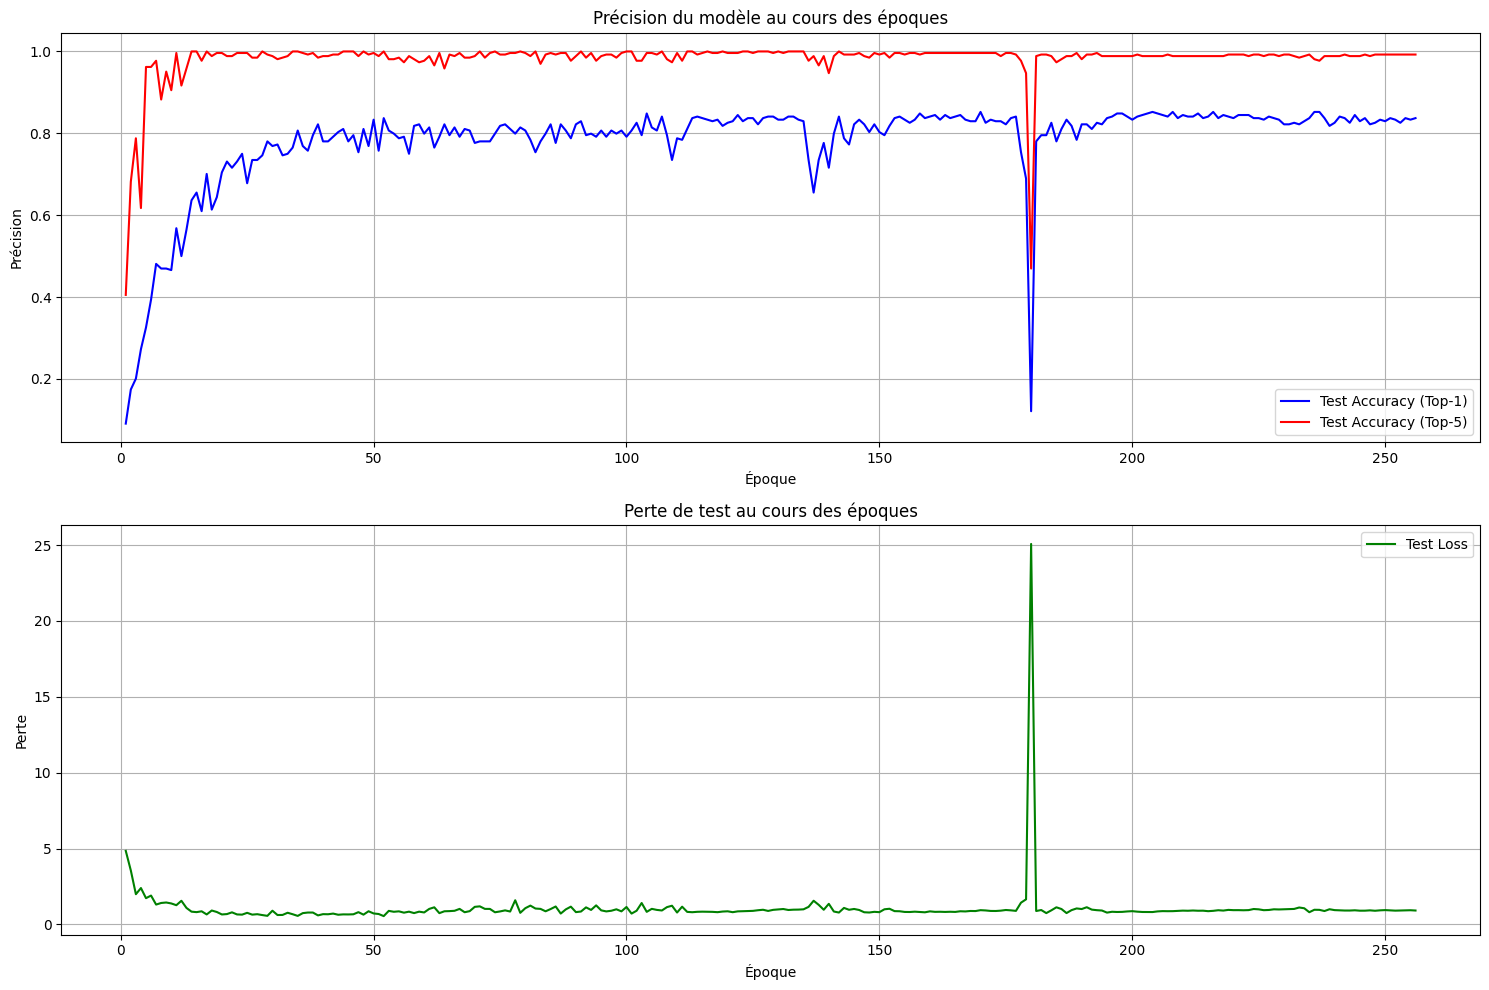

Meilleure précision: 0.8523 à l'époque 170.0


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix="_step2", top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration selon les paramètres fournis
    BEGIN_EPOCH = 0
    MAX_EPOCH = 256
    TOP_K = 5
    NAME_SUFFIX = "_step1"
    RECORD_PATH = './recorddata_DVS/'
    SAVEMODEL_PATH = './savemodels_DVS/'
    
    # 1. Visualiser à partir des fichiers .mat
    max_acc, best_epoch = plot_learning_curves(RECORD_PATH, NAME_SUFFIX, TOP_K)
    print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")

In [9]:
img, label = next(iter(test_data_loader))

In [10]:
net(img)

Taille initiale : torch.Size([12, 3, 128, 128])
Après bloc 0 (firstconv3x3) : torch.Size([12, 32, 128, 128])
Après bloc 1 (BasicBlock) : torch.Size([12, 64, 128, 128])
Après bloc 2 (BasicBlock) : torch.Size([12, 128, 64, 64])
Après bloc 3 (BasicBlock) : torch.Size([12, 128, 64, 64])
Après bloc 4 (BasicBlock) : torch.Size([12, 256, 32, 32])
Après bloc 5 (BasicBlock) : torch.Size([12, 256, 32, 32])
Après bloc 6 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 7 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 8 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 9 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 10 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 11 (BasicBlock) : torch.Size([12, 512, 16, 16])
Après bloc 12 (BasicBlock) : torch.Size([12, 1024, 8, 8])
Après bloc 13 (BasicBlock) : torch.Size([12, 1024, 8, 8])
Après pooling : torch.Size([12, 1024, 1, 1])
Après reshape : torch.Size([12, 1024])
Après couche fully connected : torch.Size([12, 11]

tensor([[ 0.3459,  0.6830, -0.4791, -0.3720, -0.4690,  0.3966,  0.2919,  0.5269,
         -0.0819,  0.5827,  1.1379],
        [ 0.0487,  0.5250, -0.4252, -0.2330, -0.3013,  0.3113,  0.3184,  0.5010,
         -0.0647,  0.5537,  1.0427],
        [ 0.1250,  0.5393, -0.3439, -0.2561, -0.3041,  0.3107,  0.2875,  0.5020,
         -0.0998,  0.5243,  1.0555],
        [ 0.1410,  0.5541, -0.4237, -0.2379, -0.3677,  0.3419,  0.3232,  0.5002,
         -0.0881,  0.5335,  1.0505],
        [ 0.2662,  0.6689, -0.4440, -0.3514, -0.4352,  0.3502,  0.3028,  0.5082,
         -0.0901,  0.5584,  1.1725],
        [ 0.3191,  0.6739, -0.4519, -0.3165, -0.4311,  0.3751,  0.3027,  0.5300,
         -0.1070,  0.5730,  1.1575],
        [ 0.2065,  0.6050, -0.4434, -0.2887, -0.3714,  0.3584,  0.3121,  0.4811,
         -0.0789,  0.5599,  1.1292],
        [ 0.1069,  0.6050, -0.4249, -0.2421, -0.3352,  0.3320,  0.3154,  0.4962,
         -0.1054,  0.5674,  1.0902],
        [ 0.3549,  0.7185, -0.4754, -0.3375, -0.4780,  0

In [26]:
img = test_data_loader.dataset[0][0]
img = img.unsqueeze(0) 

In [29]:
net.eval()

# Prédiction sans calculer de gradients
with torch.no_grad():
    img = img.cuda()
    output = net(img)     # Sortie: [1, 11]
    print(output)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
label

tensor([ 7,  5,  6,  4,  2,  8,  9, 10,  0,  3,  1,  7])

In [39]:
img[0][0].max(), img[0][0].min(), img[0][0].mean(), img[0][0].std()

(tensor(1.), tensor(0.), tensor(0.0187), tensor(0.0726))

In [54]:
dataset_train

DVSGesture

In [33]:
im,label = next(iter(test_data_loader))
print(im)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0

In [39]:
im = im.cuda()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
